In [1]:

# from utils import plot_network, plot_matrix

import networkx as nx
# import metis
# import pandas as pd
from scipy.sparse import csc_matrix, csr_matrix, save_npz
import scipy.sparse.csgraph as csgraph
import nxmetis
import scipy
import numpy as np
from bbd_matrix import bbd_matrix, block_vector
import time
import numpy as np
import scipy.sparse.linalg as la
import scipy.sparse as sp
import time
from bbd_matrix import *
from bbd_matrix import bbd_matrix
from partitionutil import *

In [2]:


# Obtaining the BBD Matrix
J_csr = scipy.sparse.load_npz('csr_70k.npz') #Loadd the case file (obtained from ANDES)
A = J_csr
BBD, index_order = admittance_to_BBD(A,5)

# array = BBD.to_dense()


# import matplotlib.pyplot as plt # Visualizing it
# plt.figure(figsize = (8,6))
# plt.spy(array, markersize = 5)
# plt.title('BBD Matrix')
# plt.xlabel('Col Index')
# plt.ylabel('Row Index')
# plt.show()

%timeit -r 3 -n 3 admittance_to_BBD(A,5)



    Graph:          7.60e+00    0.14%
    NxMetis:        1.12e+00    0.02%
    OutN:           8.82e-06    0.00%
    PartE:          2.99e+03   54.68%
    ComE:           2.47e+03   45.09%
    ComN:           3.49e-04    0.00%
    PartN:          9.47e-03    0.00%
    AllGr:          6.37e-02    0.00%
    IdxOrd:         3.47e+00    0.06%
    CrnOrd:         1.60e-02    0.00%
    Final:          6.23e-02    0.00%
    BlkSort:        9.18e-02    0.00%
    BBD:            7.47e-03    0.00%
    Total:          5.47e+03
    

        Partition Size:       5
        Total NNZ:       969583
        Min Block Size:   29795
        Min Block NNZ:   189725
        Max Block Size:   30013
        Max Block NNZ:   196692
        Corner Size:        930
        Corner NNZ:        4140
        

    Graph:          6.52e+00    0.11%
    NxMetis:        1.09e+00    0.02%
    OutN:           7.39e-06    0.00%
    PartE:          3.29e+03   56.92%
    ComE:           2.48e+03   42.89%
    ComN:     

In [3]:
# Obtaining LU Matrices 
from line_profiler import LineProfiler

def schur_lu(A_bbd, dense_corner=False):

    L = bbd_matrix(A_bbd.block_dim)
    U = bbd_matrix(A_bbd.block_dim)

    for idx in A_bbd.diag_blocks.keys():
            
        Aii = A_bbd.diag_blocks[idx]
        Ain = A_bbd.right_blocks[idx]
        Ani = A_bbd.lower_blocks[idx]

        N = Aii.shape[0]

        lu = la.splu(Aii.tocsc(), permc_spec="NATURAL")
        L.diag_blocks[idx] = lu.L[lu.perm_r,:]
        U.diag_blocks[idx] = lu.U

        L.lower_blocks[idx] = la.spsolve(lu.U.transpose().tocsc(),
                                         Ani.transpose().tocsc()
                                         ).transpose()
        U.right_blocks[idx] = la.spsolve(L.diag_blocks[idx], Ain.tocsc())

    N = A_bbd.corner.shape[0]
    B = sp.csc_matrix((N,N))
    for idx in A_bbd.diag_blocks.keys():
        B += L.lower_blocks[idx] @ U.right_blocks[idx]

    lu = la.splu(A_bbd.corner.tocsc() - B)
    L.corner = lu.L[lu.perm_r,:]
    U.corner = lu.U[:,lu.perm_c]

    if dense_corner:
        L.corner = L.corner.todense()
        U.corner = U.corner.todense()

    L.complete = True
    U.complete = True

    return (L, U)

A_bbd = BBD

block_sizes = A_bbd.block_sizes
a = L.diag_blocks



False

In [6]:
b_dense = np.ones(J_csr.shape[0])
b_bv = block_vector(A_bbd.block_sizes, x_dense=b_dense)

from line_profiler import LineProfiler 
import scipy.sparse.linalg 
from multiprocessing import Pool

class schur_bbd_lu:
    def __init__(self, A_bbd, dense_corner=False):

        (self.L, self.U) = schur_lu(A_bbd, dense_corner=dense_corner)

        self.block_sizes = A_bbd.block_sizes

        self.dense_corner = dense_corner

        self.t_formbv = 0.0
        self.t_forward = 0.0
        self.t_backward = 0.0

        self.tf_yloop = 0.0
        self.tf_csolve = 0.0

        self.tb_csolve = 0.0
        self.tb_loop = 0.0

        self.solves = 0

        return

    
    def solve_blocks(self, idx, diag_block, b_block):
        y_val = la.spsolve(diag_block, b_block)
        return idx, y_val
    
    def _schur_forward(self, b_bv):
        

        t0 = time.time()

        L = self.L

        c = np.zeros(self.L.corner.shape[0])
        y = {}
        y = {idx: scipy.sparse.linalg.spsolve(self.L.diag_blocks[idx], b_bv[idx], permc_spec="NATURAL") for idx in self.L.diag_blocks.keys()} # Modified
        # y = scipy.sparse.linalg.spsolve(self.L.diag_blocks[0], b_bv[0], permc_spec="NATURAL") # Original
        c = sum([L.lower_blocks[idx] @ y[idx] for idx in L.diag_blocks.keys()], c)

        t1 = time.time()

        if self.dense_corner:
            yn = dla.solve(L.corner, b_bv[L.block_dim - 1] - c)
        else:
            yn = la.spsolve(L.corner, b_bv[L.block_dim - 1] - c)

        t2 = time.time()

        self.tf_yloop += t1 - t0
        self.tf_csolve += t2 - t1

        return (y, yn)


    def _schur_backward(self, y, yn, block_sizes):

        t0 = time.time()

        U = self.U

        if self.dense_corner:
            xn = dla.solve(U.corner, yn)
        else:
            xn = la.spsolve(U.corner, yn)

        t1 = time.time()
            

        x_bv = block_vector(block_sizes)
        for idx in U.diag_blocks.keys():
            rhs_i = y[idx] - U.right_blocks[idx] @ xn
            x_bv[idx] = la.spsolve(U.diag_blocks[idx], rhs_i, permc_spec="NATURAL")
        x_bv[U.block_dim - 1] = xn

        t2 = time.time()

        self.tb_csolve += t1 - t0
        self.tb_loop += t2 - t1

        return x_bv.to_dense()

    def schur_solve(self):

        t0 = time.time()

        b_bv = block_vector(self.block_sizes, x_dense=b_dense)

        t1 = time.time()

        (y, yn) = self._schur_forward(b_bv)

        t2 = time.time()

        x_bv = self._schur_backward(y, yn, b_bv.sizes)

        t3 = time.time()

        self.t_formbv += t1 - t0
        self.t_forward += t2 - t1
        self.t_backward += t3 - t2
        self.solves += 1

        return x_bv

    def print_timing(self):

        total = self.t_forward + self.t_backward
        time_str = """
        Calls:      {:d}
        BlkVectr:   {:10.2e} {:8.2%} {:8.2e}
        Forward:    {:10.2e} {:8.2%} {:8.2e}
          FLoop:    {:10.2e} {:8.2%} {:8.2e}
          FCSolve:  {:10.2e} {:8.2%} {:8.2e}
        Backward:   {:10.2e} {:8.2%} {:8.2e}
          BCSolve:  {:10.2e} {:8.2%} {:8.2e}
          BLoop:    {:10.2e} {:8.2%} {:8.2e}
        SchurSolve: {:10.2e}
        """.format(
            self.solves,
            self.t_formbv, self.t_formbv/total, self.t_formbv/self.solves,
            self.t_forward, self.t_forward/total, self.t_forward/self.solves,
            self.tf_yloop, self.tf_yloop/total, self.tf_yloop/self.solves,
            self.tf_csolve, self.tf_csolve/total, self.tf_csolve/self.solves,
            self.t_backward, self.t_backward/total, self.t_backward/self.solves,
            self.tb_csolve, self.tb_csolve/total, self.tb_csolve/self.solves,
            self.tb_loop, self.tb_loop/total, self.tb_loop/self.solves,
            total,
        )

        print(time_str)

        return

    def print_summary(self):

        lsum = self.L.summarize()
        usum = self.U.summarize()

        bbd_str = """
        **** {0} Summary ****
        {0} Total NNZ:      {1:7d}
        {0} Min Block Size: {2:7d}
        {0} Min Block NNZ:  {3:7d}
        {0} Max Block Size: {4:7d}
        {0} Max Block NNZ:  {5:7d}
        {0} Corner Size:    {6:7d}
        {0} Corner NNZ:     {7:7d}
        """

        print(bbd_str.format(
            'L',
            lsum[0],
            lsum[1],
            lsum[2],
            lsum[3],
            lsum[4],
            lsum[5],
            lsum[6],
        ))

        print(bbd_str.format(
            'U',
            usum[0],
            usum[1],
            usum[2],
            usum[3],
            usum[4],
            usum[5],
            usum[6],
        ))

        return
    
BBD_solve = schur_bbd_lu(A_bbd)
b_dense = np.ones(BBD.shape[0])
b_bv = block_vector(A_bbd.block_sizes, x_dense=b_dense)

# y = BBD_solve._schur_forward(b_bv)
# x_bv = BBD_solve.schur_solve(b_dense)
# BBD_solve.print_timing()
# BBD_solve.print_summary()

# %load_ext line_profiler
# import timeit
# %lprun -f schur_bbd_lu.schur_solve BBD_solve.schur_solve(b_dense)
# a = timeit.repeat(BBD_solve.schur_solve, repeat = 100, number = 1)
# avg = np.mean(a)
# min = np.min(a)
# max = np.max(a)
# std = np.std(a)
# print(avg, min, max, std)
%timeit -r 3 -n 3 BBD_solve.schur_solve()


574 ms ± 36.4 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [ ]:
plt.spy(L.diag_blocks[0]) # To obtain plot of any diagonal block

In [33]:
# Linear solver

import timeit
import scipy.sparse.linalg as la 
import scipy.sparse
import numpy as np
import cupy as cp


A = scipy.sparse.load_npz('csr_70k_5parts.npz')

b = np.ones(A.shape[0])


    
def relative_error():

    x = la.spsolve(A, b, permc_spec='COLAMD') # Change to NATURAL for comparison as needed.

    return x
    


# avg = np.mean(a)
# min = np.min(a)
# max = np.max(a)
# std = np.std(a)
# print(avg, min, max, std)
# %lprun -f relative_error relative_error(J_csr2, b)

%timeit relative_error()





723 ms ± 89.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


" Line profiling shows that a major portion of the time is taken\nup by superLU - a set of routines for solving large, sparse, \nand non-symmetric matrices. 'gssv' solves Ax = b directly \nusing LU decomposition "

In [ ]:
# Obtaining dense row and dense column counts

row_counts = np.diff(a[0].indptr)
print(row_counts)
threshold = np.max(row_counts)/2
dense_rows = np.sum(row_counts >= threshold)
print(dense_rows)

col_counts = np.bincount(A.indices, minlength=A.shape[1])
threshold = np.max(col_counts)/2
dense_cols = np.sum(col_counts >= threshold)
print(dense_cols)




In [23]:
# Obtaining matrix shape, nnz, nnz%, and LU nnz using NATURAL permutation, respectively, for the diagonal blocks

from scipy.sparse.linalg import splu
zz = a[0]
B = splu(zz, permc_spec='NATURAL')
L = B.L
U = B.U
print(zz.shape[0])
print(zz.nnz)
print(100*zz.nnz/(zz.shape[0]*zz.shape[0]))
print(L.nnz)
print(U.nnz)

29834
784463
0.08813522015400818
784525
657662


In [ ]:
# Obtaining matrix shape, nnz, nnz%, and LU nnz using NATURAL permutation, respectively, for the BBD matrix
B = splu(A, permc_spec='NATURAL')
L = B.L
U = B.U
print(A.nnz/A.shape[0])
print(L.nnz)
print(U.nnz)

In [ ]:
# For high quality BBD plots

plt.figure(figsize=(8, 8))  # Increase the figure size for better resolution
plt.spy(a[4], markersize=0.5, precision='present')  # Adjust markersize for better detail

# Customize the plot for higher quality
plt.title('BBD Matrix  - 70k Bus Case with 15 Partitions - Block 5')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.grid(True)
plt.tight_layout()

In [35]:
# Obtaining dense row and dense column counts - SAME AS ABOVE

aa = a[2]
import numpy as np
row_counts = np.diff(aa.indptr)
b = np.max(row_counts)
c = np.average(row_counts)
dense_rows = np.sum(row_counts > 0.50*b)
print(aa.shape[0])
print(dense_rows)
print(100*dense_rows/aa.shape[0])

col_counts = np.bincount(aa.indices, minlength=aa.shape[1])
d = np.max(col_counts)
e = np.average(col_counts)
dense_cols = np.sum(col_counts > 0.50*d)
print(dense_cols)
print(100*dense_cols/aa.shape[1])


29912
1955
6.535838459481145
48
0.16047071409467772


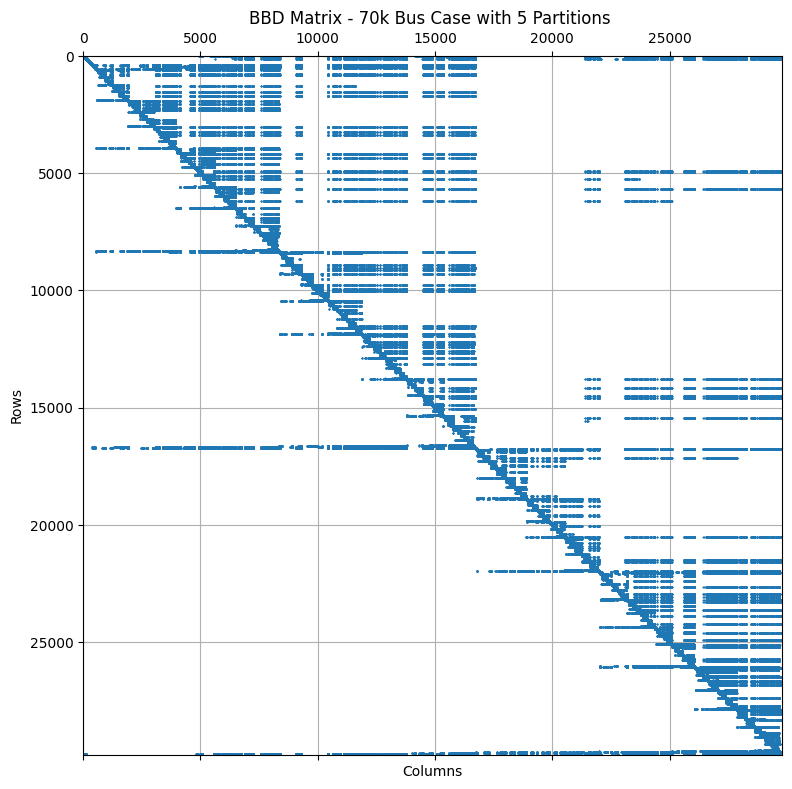

In [32]:
import matplotlib.pyplot as plt
# For high quality BLOCK plots

plt.figure(figsize=(8, 8))  # Increase the figure size for better resolution
plt.spy(A, markersize=0.5, precision='present')  # Adjust markersize for better detail

# Customize the plot for higher quality
plt.title('BBD Matrix - 70k Bus Case with 5 Partitions ')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.grid(True)
plt.tight_layout()